---
title: # Introduction to Image Analysis using Galaxy
subtitle: Learn how to use Jupyter Notebook in Galaxy to perform image analysis
authors:
  - name: Anne Fouilloux
    orcid: 0000-0002-1784-2920
    github: annefou
    affiliations:
      - id: Simula Research Laboratory
        institution: Simula Research Laboratory
        ror: 00vn06n10
date: 2025-02-16
thumbnail: 
keywords : image analysis
releaseDate: 2025-02-16
datePublished: 2025-02-16
dateModified: 2025-02-16
---

## Install required packages

In [1]:
pip install pooch scikit-image matplotlib

Note: you may need to restart the kernel to use updated packages.


## Getting Data

In [2]:
import pooch
import os

In [3]:
data_folder = "./data"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

In [4]:
unzipped_files = pooch.retrieve(
    url="doi:10.5281/zenodo.3362976/B2.zip",
    known_hash="md5:a263701011da9d289eaa35a39a225577",
    processor=pooch.Unzip(extract_dir="data"),
    path=".",
)

## Select file of interest

In [5]:
file_to_process = "data/B2--W00026--P00001--Z00000--T00000--dapi.tif"

## Open and read file

In [6]:
from skimage.io import imread

In [7]:
img = imread(file_to_process)

## Get metadata

In [8]:
img.dtype

dtype('uint16')

In [9]:
img.shape

(1024, 1344)

In [10]:
img

array([[33372, 33358, 33350, ..., 33092, 33084, 33089],
       [33315, 33316, 33322, ..., 33076, 33086, 33087],
       [33221, 33222, 33245, ..., 33086, 33069, 33074],
       ...,
       [33187, 33170, 33166, ..., 33114, 33127, 33131],
       [33198, 33176, 33170, ..., 33129, 33132, 33129],
       [33223, 33191, 33191, ..., 33122, 33120, 33128]], dtype=uint16)

## Visualize image

In [11]:
import matplotlib.pyplot as plt

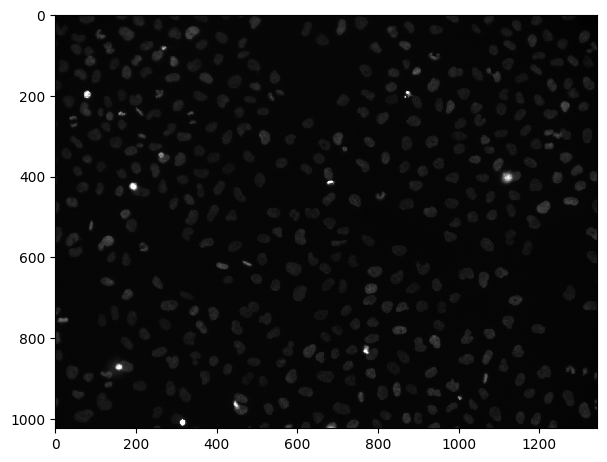

In [12]:
plt.figure(figsize=(7, 7))
plt.imshow(img, interpolation="none", cmap="gray")
plt.show()

## Apply Histogram equalization algorithm

In [13]:
import skimage

In [14]:
img_eq = skimage.exposure.equalize_adapthist(img)
img_eq = skimage.util.img_as_uint(img_eq)

## Visualize normalized image

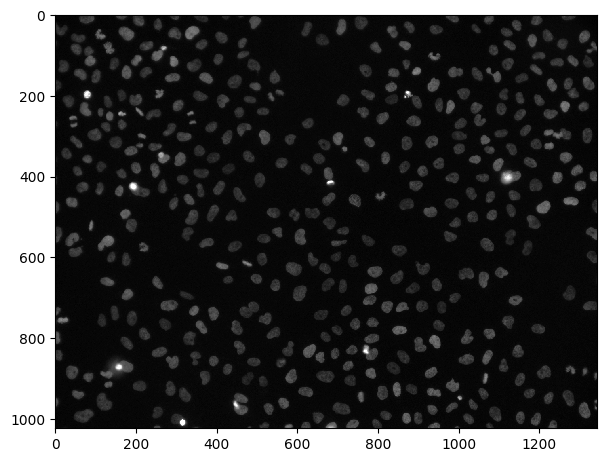

In [15]:
plt.figure(figsize=(7, 7))
plt.imshow(img_eq, interpolation="none", cmap="gray")
plt.show()

## Define function to normalize and visualize images 

In [16]:
def visualize(img):
    img_eq = skimage.exposure.equalize_adapthist(img)
    img_eq = skimage.util.img_as_uint(img_eq)
    plt.figure(figsize=(7, 7))
    plt.imshow(img_eq, interpolation="none", cmap="gray")
    plt.show()

## Image Filtering
Specific features of interest (e.g., edges, noise) can be enhanced or suppressed by using an image filter.

In [17]:
import scipy.ndimage as ndi

In [18]:
sigma = 3.0

In [19]:
img_filtered = ndi.gaussian_filter(img, sigma)

## Visualize filtered image

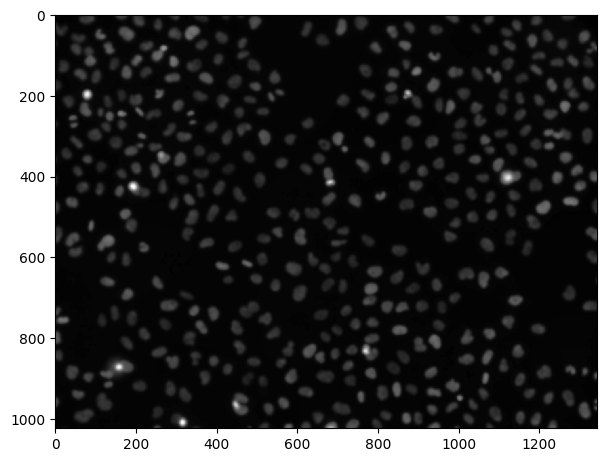

In [20]:
visualize(img_filtered)

## Segmentation
Objects of interest like nuclei can be segmented by using a smoothed image and thresholding. Moreover, the results can be overlayed with the original image.

In [21]:
import numpy as np

In [22]:
img = np.squeeze(img_filtered)

th = skimage.filters.threshold_otsu(img_filtered)
img_segmented = img_filtered > th

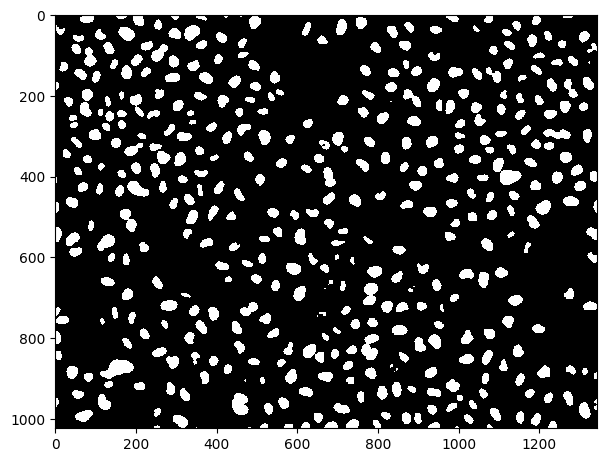

In [23]:
visualize(img_segmented)

In [24]:
from skimage.measure import label

In [25]:
img_label = label(img_segmented)
img_label = skimage.util.img_as_uint(img_label)

/opt/conda/lib/python3.11/site-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int32 to uint16 without scaling because max value 425 fits in uint16
  return _convert(image, np.uint16, force_copy)


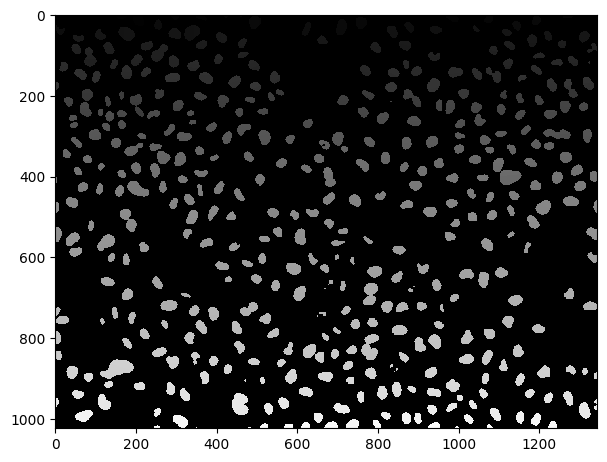

In [26]:
visualize(img_label)

## Overlay images

In [27]:
import numpy as np
import skimage.morphology as morph
import matplotlib

## Define functions 

### get_rgb8_copy

This function ensures that the input image:
- Is always an RGB image (3 channels)
- Has a uint8 data type
- Can accept grayscale, RGB, or RGBA inputs in various formats (float, uint16, or uint8)

In [28]:
def get_rgb8_copy(img):
    # Ensure the image is queezed
    img = np.squeeze(img)
    # Check that the image has a valid shape
    assert img.ndim == 2 or (img.ndim == 3 and img.shape[-1] in (3, 4))
    # Convert the pixel values to np.uint8 if necessary
    if str(img.dtype).startswith("float"):
        img = np.round(img * 255).astype(np.uint8)
    elif img.dtype == np.uint16:
        img = (img // 256).astype(np.uint8)
    elif img.dtype != np.uint8:
        raise ValueError(f"unknown dtype: {img.dtype}")
    # Ensure the image has 3 channels (RGB)
    if img.ndim == 2:
        result = np.dstack([img] * 3).copy()
    else:
        result = img[:, :, :3].copy()
    # return the final output as an 8-bit (uint8) image
    assert result.dtype == np.uint8, result.dtype
    return result

### Segmentation contour

- Input:
  - img: Original image (grayscale or color).
  - labels: Segmentation mask (integer labels for regions).
  - linewidth: Thickness of the contour lines.
  - color: Contour color (default: red).
  - label_color: Label text color (default: yellow).


- Output:
  - Image with segmented contours drawn in the specified color.
  - Overlay labels at region centroids.

In [29]:
def seg_contour(img, labels, linewidth, color="#ff0000", label_color="#ffff00"):
    # Prepare the Image in RGB Format (uint8)
    result = get_rgb8_copy(img)
    # Define Structuring Elements for Contours
    selem_inner = morph.disk(linewidth - linewidth // 2)
    selem_outer = morph.disk(linewidth // 2)
    # Convert Color to RGB Values (0-255 Scale)
    color_rgb = np.multiply(255, matplotlib.colors.to_rgb(color))

    # Loop Over Unique Labels (Ignoring Background label=0)
    for one_label in np.unique(labels):
        if one_label > 0:
            cc = labels == one_label
            # Extract Inner and Outer Contours
            inner_contour = np.logical_xor(cc, morph.binary_erosion(cc, selem_inner))
            outer_contour = np.logical_and(
                np.logical_not(labels), morph.binary_dilation(cc, selem_outer)
            )
            # Overlay Contour on Image
            bd = np.logical_or(inner_contour, outer_contour)
            for i in range(3):
                result[:, :, i][bd] = color_rgb[i]

    # Plot the Image with Contours
    fig = plt.figure(figsize=np.divide(img.shape[:2][::-1], 100), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis("off")
    ax.imshow(result)
    # Overlay Labels at Centroids
    for reg in skimage.measure.regionprops(labels):
        ax.text(reg.centroid[1], reg.centroid[0], str(reg.label), color=label_color)

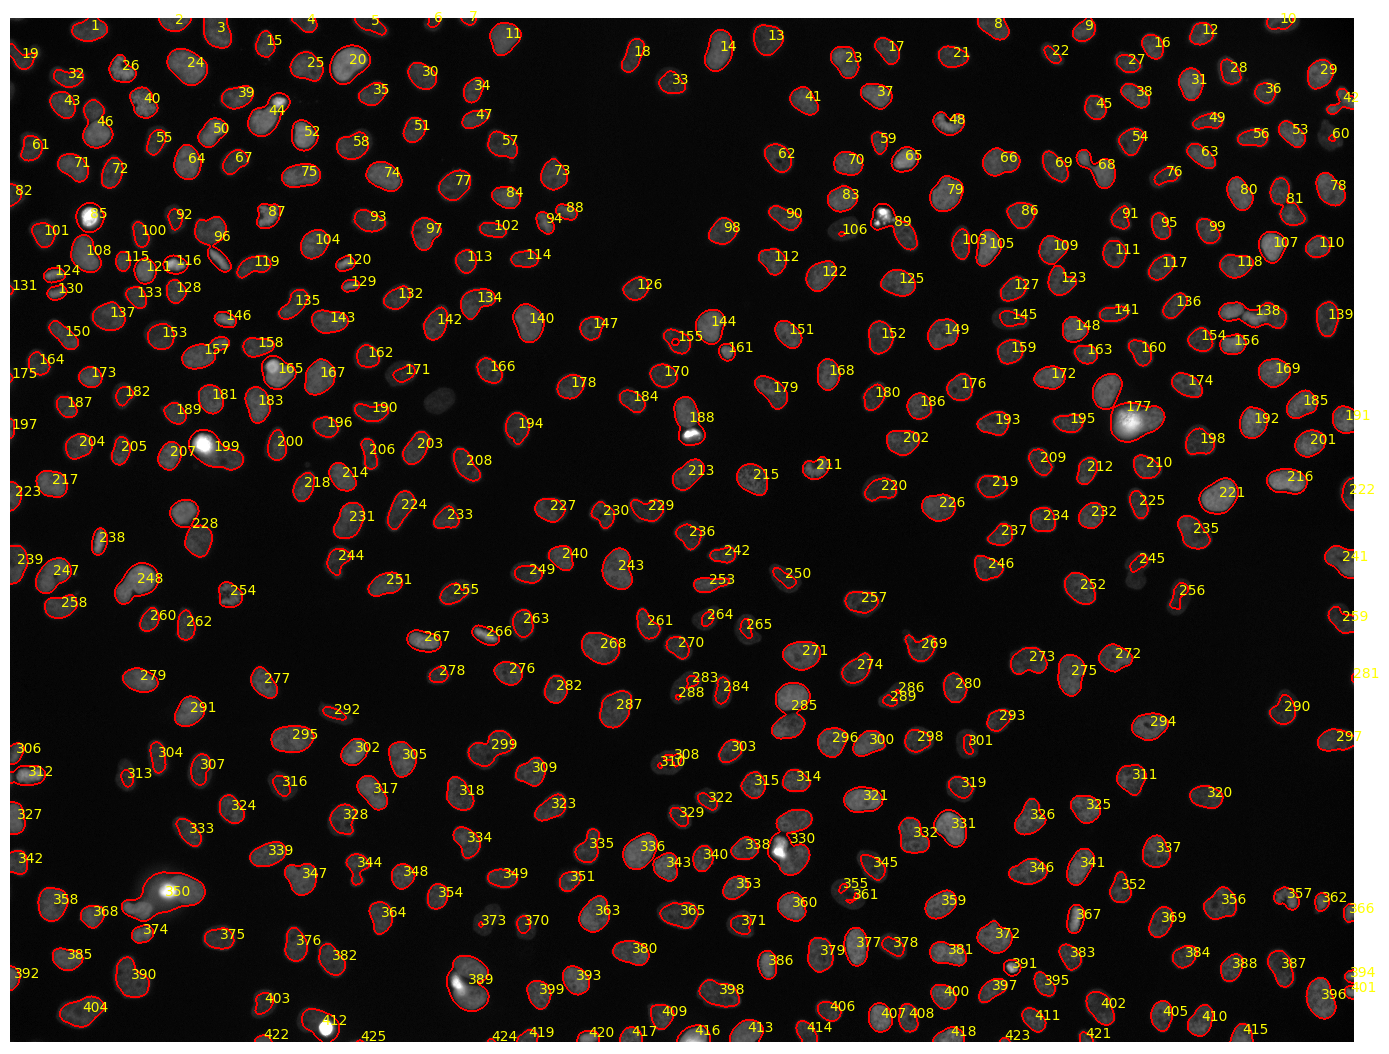

In [30]:
seg_contour(img_eq, img_label, linewidth=2, color="red", label_color="yellow")